In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
lin = nn.Linear(5, 3)  # maps from R^5 to R^3, parameters A, b
# data is 2x5.  A maps from 5 to 3... can we map "data" under A?
data = torch.randn(2, 5)
print(lin(data))  # yes

tensor([[ 0.1755, -0.3268, -0.5069],
        [-0.6602,  0.2260,  0.1089]], grad_fn=<AddmmBackward>)


In [3]:
# In pytorch, most non-linearities are in torch.functional (we have it imported as F)
# Note that non-linearites typically don't have parameters like affine maps do.
# That is, they don't have weights that are updated during training.
data = torch.randn(2, 2)
print(data)
print(F.relu(data))


tensor([[-0.5404, -2.2102],
        [ 2.1130, -0.0040]])
tensor([[0.0000, 0.0000],
        [2.1130, 0.0000]])


In [4]:
# Softmax is also in torch.nn.functional
data = torch.randn(5)
print(data)
print(F.softmax(data, dim=0))
print(F.softmax(data, dim=0).sum())  # Sums to 1 because it is a distribution!
print(F.log_softmax(data, dim=0))  # theres also log_softmax


tensor([ 1.3800, -1.3505,  0.3455,  0.5046,  1.8213])
tensor([0.2948, 0.0192, 0.1048, 0.1228, 0.4584])
tensor(1.)
tensor([-1.2214, -3.9519, -2.2560, -2.0969, -0.7801])


In [5]:
data = [("me gusta comer en la cafeteria".split(), "SPANISH"),
        ("Give it to me".split(), "ENGLISH"),
        ("No creo que sea una buena idea".split(), "SPANISH"),
        ("No it is not a good idea to get lost at sea".split(), "ENGLISH")]

test_data = [("Yo creo que si".split(), "SPANISH"),
             ("it is lost on me".split(), "ENGLISH")]

# word_to_ix maps each word in the vocab to a unique integer, which will be its
# index into the Bag of words vector
word_to_ix = {}
for sent, _ in data + test_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2


{'me': 0, 'gusta': 1, 'comer': 2, 'en': 3, 'la': 4, 'cafeteria': 5, 'Give': 6, 'it': 7, 'to': 8, 'No': 9, 'creo': 10, 'que': 11, 'sea': 12, 'una': 13, 'buena': 14, 'idea': 15, 'is': 16, 'not': 17, 'a': 18, 'good': 19, 'get': 20, 'lost': 21, 'at': 22, 'Yo': 23, 'si': 24, 'on': 25}


In [6]:
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()

        # Define the parameters that you will need.  In this case, we need A and b,
        # the parameters of the affine mapping.
        # Torch defines nn.Linear(), which provides the affine map.
        # Make sure you understand why the input dimension is vocab_size
        # and the output is num_labels!
        self.linear = nn.Linear(vocab_size, num_labels)

        # NOTE! The non-linearity log softmax does not have parameters! So we don't need
        # to worry about that here

    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [7]:
def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1
    return vec.view(1, -1)


def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]])


In [8]:
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)

# the model knows its parameters.  The first output below is A, the second is b.
# Whenever you assign a component to a class variable in the __init__ function
# of a module, which was done with the line
# self.linear = nn.Linear(...)
# Then through some Python magic from the PyTorch devs, your module
# (in this case, BoWClassifier) will store knowledge of the nn.Linear's parameters
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1194,  0.0609, -0.1268,  0.1274,  0.1191,  0.1739, -0.1099, -0.0323,
         -0.0038,  0.0286, -0.1488, -0.1392,  0.1067, -0.0460,  0.0958,  0.0112,
          0.0644,  0.0431,  0.0713,  0.0972, -0.1816,  0.0987, -0.1379, -0.1480,
          0.0119, -0.0334],
        [ 0.1152, -0.1136, -0.1743,  0.1427, -0.0291,  0.1103,  0.0630, -0.1471,
          0.0394,  0.0471, -0.1313, -0.0931,  0.0669,  0.0351, -0.0834, -0.0594,
          0.1796, -0.0363,  0.1106,  0.0849, -0.1268, -0.1668,  0.1882,  0.0102,
          0.1344,  0.0406]], requires_grad=True)
Parameter containing:
tensor([0.0631, 0.1465], requires_grad=True)


In [9]:
with torch.no_grad():
    sample = data[0]
    bow_vector = make_bow_vector(sample[0], word_to_ix)
    log_probs = model(bow_vector)
    print(log_probs)

tensor([[-0.5378, -0.8771]])


In [10]:
label_to_ix = {"SPANISH": 0, "ENGLISH": 1}

In [11]:
with torch.no_grad():
    for instance, label in test_data:
        bow_vec = make_bow_vector(instance, word_to_ix)
        log_probs = model(bow_vec)
        print(log_probs)

# Print the matrix column corresponding to "creo"
print(next(model.parameters())[:, word_to_ix["creo"]])

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

tensor([[-0.9297, -0.5020]])
tensor([[-0.6388, -0.7506]])
tensor([-0.1488, -0.1313], grad_fn=<SelectBackward>)


In [12]:
for epoch in range(100):
    for instance, label in data:
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Make our BOW vector and also we must wrap the target in a
        # Tensor as an integer. For example, if the target is SPANISH, then
        # we wrap the integer 0. The loss function then knows that the 0th
        # element of the log probabilities is the log probability
        # corresponding to SPANISH
        bow_vec = make_bow_vector(instance, word_to_ix)
        target = make_target(label, label_to_ix)

        # Step 3. Run our forward pass.
        log_probs = model(bow_vec)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()

In [13]:
with torch.no_grad():
    for instance, label in test_data:
        bow_vec = make_bow_vector(instance, word_to_ix)
        log_probs = model(bow_vec)
        print(log_probs)


tensor([[-0.2093, -1.6669]])
tensor([[-2.5330, -0.0828]])


In [14]:
print(next(model.parameters())[:, word_to_ix["creo"]])

tensor([ 0.2803, -0.5605], grad_fn=<SelectBackward>)


In [15]:
!pip install -q seaborn

In [16]:
import seaborn

In [17]:
dir(seaborn)

['FacetGrid',
 'JointGrid',
 'PairGrid',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_orig_rc_params',
 'algorithms',
 'axes_style',
 'axisgrid',
 'barplot',
 'blend_palette',
 'boxenplot',
 'boxplot',
 'categorical',
 'catplot',
 'choose_colorbrewer_palette',
 'choose_cubehelix_palette',
 'choose_dark_palette',
 'choose_diverging_palette',
 'choose_light_palette',
 'clustermap',
 'cm',
 'color_palette',
 'colors',
 'countplot',
 'crayon_palette',
 'crayons',
 'cubehelix_palette',
 'dark_palette',
 'desaturate',
 'despine',
 'distplot',
 'distributions',
 'diverging_palette',
 'dogplot',
 'external',
 'factorplot',
 'get_dataset_names',
 'heatmap',
 'hls_palette',
 'husl_palette',
 'jointplot',
 'kdeplot',
 'light_palette',
 'lineplot',
 'lmplot',
 'load_dataset',
 'lvplot',
 'matrix',
 'miscplot',
 'mpl',
 'mpl_palette',
 'pairplot',
 'palettes',
 'palplot',
 'plotting_context',
 'poin

In [18]:
searborn.xkcd_rgb

NameError: name 'searborn' is not defined

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set_style(style = 'whitegrid')
plt.rcParams["patch.force_edgecolor"] = True

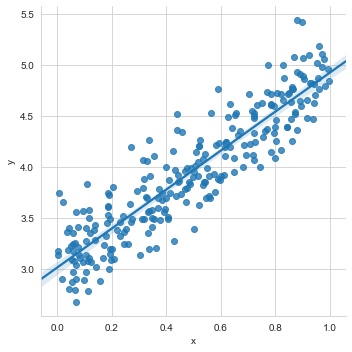

In [20]:
m = 2 # slope
c = 3 # interceptm = 2 # slope
c = 3 # intercept
x = np.random.rand(256)

noise = np.random.randn(256) / 4

y = x * m + c + noise

df = pd.DataFrame()
df['x'] = x
df['y'] = y

sns.lmplot(x ='x', y ='y', data = df)

In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable
x_train = x.reshape(-1, 1).astype('float32')
y_train = y.reshape(-1, 1).astype('float32')

class LinearRegressionModel(nn.Module):
   def __init__(self, input_dim, output_dim):
      super(LinearRegressionModel, self).__init__()
      self.linear = nn.Linear(input_dim, output_dim)

   def forward(self, x):
      out = self.linear(x)
      return out
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
input_dim, output_dim(1, 1)
model = LinearRegressionModel(input_dim, output_dim)
criterion = nn.MSELoss()
[w, b] = model.parameters()

def get_param_values():
   return w.data[0][0], b.data[0]

def plot_current_fit(title = ""):
plt.figure(figsize = (12,4))
plt.title(title)
plt.scatter(x, y, s = 8)
w1 = w.data[0][0]
b1 = b.data[0]
x1 = np.array([0., 1.])
y1 = x1 * w1 + b1
plt.plot(x1, y1, 'r', label = 'Current Fit ({:.3f}, {:.3f})'.format(w1, b1))
plt.xlabel('x (input)')
plt.ylabel('y (target)')
plt.legend()
plt.show()
plot_current_fit('Before training')

IndentationError: expected an indented block (<ipython-input-21-0f7ee380762a>, line 26)

In [22]:
import matplotlib.pyplot as plt

In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable
x_train = x.reshape(-1, 1).astype('float32')
y_train = y.reshape(-1, 1).astype('float32')

In [24]:
class LinearRegressionModel(nn.Module):
   def __init__(self, input_dim, output_dim):
      super(LinearRegressionModel, self).__init__()
      self.linear = nn.Linear(input_dim, output_dim)

   def forward(self, x):
      out = self.linear(x)
      return out

In [25]:
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
input_dim, output_dim(1, 1)
model = LinearRegressionModel(input_dim, output_dim)
criterion = nn.MSELoss()
[w, b] = model.parameters()

TypeError: 'int' object is not callable

In [26]:
def get_param_values():
   return w.data[0][0], b.data[0]

In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [28]:
input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001

# Toy dataset
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], 
                    [9.779], [6.182], [7.59], [2.167], [7.042], 
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], 
                    [3.366], [2.596], [2.53], [1.221], [2.827], 
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

In [29]:
# Linear regression model
model = nn.Linear(input_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


In [30]:
# Train the model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [5/60], Loss: 5.2954
Epoch [10/60], Loss: 2.4153
Epoch [15/60], Loss: 1.2481
Epoch [20/60], Loss: 0.7749
Epoch [25/60], Loss: 0.5827
Epoch [30/60], Loss: 0.5044
Epoch [35/60], Loss: 0.4723
Epoch [40/60], Loss: 0.4588
Epoch [45/60], Loss: 0.4529
Epoch [50/60], Loss: 0.4501
Epoch [55/60], Loss: 0.4486
Epoch [60/60], Loss: 0.4475


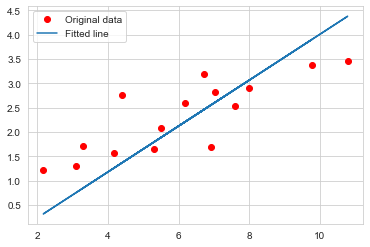

In [31]:


# Plot the graph
predicted = model(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

In [32]:
torch.save(model.state_dict(), 'model.ckpt')

In [33]:
torch

<module 'torch' from '/Users/dushyantmistry/Projects/tensorflow/tensorflow3/lib/python3.7/site-packages/torch/__init__.py'>